###1. Set Up Environment




Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Clone Darknet repository and build it

In [9]:
!git clone https://github.com/AlexeyAB/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [10]:
pwd

'/content'

In [11]:
%cd darknet

/content/darknet


In [12]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make


chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘buff’ []8;;https://gcc.g

###2. Download Dataset from Roboflow

Install Roboflow and Download Dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="04teDGFmVsSd4X0RMEQV")
project = rf.workspace("thehafizsampersonal-pbe9x").project("human-detection-zi7fv")
version = project.version(2)
dataset = version.download("darknet")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-Detection-2 in darknet:: 100%|██████████| 1588/1588 [00:00<00:00, 3156.30it/s]


###3. Data Preparation and Cleaning

Move Data to Appropriate Directories

In [3]:
!mkdir -p data/obj

In [2]:
dataset.location

'/content/Human-Detection-2'

In [5]:
!find /content/darknet/Human-Detection-2/train/ -name "*.jpg" -exec mv {} data/obj/ \;

In [8]:
ls data/obj

In [11]:
!find /content/darknet/Human-Detection-2/train/ -name "*.txt" -exec mv {} data/obj/ \;
!find /content/darknet/Human-Detection-2/valid/ -name "*.jpg" -exec mv {} data/obj/ \;
!find /content/darknet/Human-Detection-2/valid/ -name "*.txt" -exec mv {} data/obj/ \;

^C


Create `obj.names` File

In [12]:
classes = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

with open('data/obj.names', 'w') as f:
    for cls in classes:
        f.write(f"{cls}\n")


Create `obj.data` File

In [13]:
import os

# Define the path to the backup directory
backup_directory_path = '/content/drive/MyDrive/yolo_backup/'

# Check if the directory exists
if not os.path.exists(backup_directory_path):
    # Create the directory
    os.makedirs(backup_directory_path)
    print(f"Created directory: {backup_directory_path}")
else:
    print(f"Directory already exists: {backup_directory_path}")


Directory already exists: /content/drive/MyDrive/yolo_backup/


In [14]:
import os

# Define the backup directory
backup_directory = '/content/drive/MyDrive/yolo_backup/'

# Debugging output
print(f"Backup directory: {backup_directory}")

# Prepare the lines to be written
lines_to_write = [
    f"classes = {len(classes)}",
    "train = data/train.txt",
    "valid = data/valid.txt",
    "names = data/obj.names",
    f"backup = {backup_directory}/"
]

# Write the lines to the file
with open('data/obj.data', 'w') as f:
    f.writelines(line + '\n' for line in lines_to_write)

# Debugging output after writing
print("Finished writing to obj.data")


Backup directory: /content/drive/MyDrive/yolo_backup/
Finished writing to obj.data


Create Training and Validation Text Files

In [15]:
import glob

train_images = glob.glob('data/obj/*.jpg')

with open('data/train.txt', 'w') as f:
    for image in train_images:
        f.write(f"{image}\n")

with open('data/valid.txt', 'w') as f:
    for image in train_images[:int(len(train_images) * 0.2)]:  # Use 20% for validation
        f.write(f"{image}\n")


Create and Adjust `yolov4-custom.cfg`

In [16]:
cd darknet #move to content/darknet directory to access yolov4-custom.cfg file

[Errno 2] No such file or directory: 'darknet #move to content/darknet directory to access yolov4-custom.cfg file'
/content/darknet


In [17]:
!cp cfg/yolov4-custom.cfg cfg/custom-yolov4-detector.cfg

!sed -i 's/batch=64/batch=16/' cfg/custom-yolov4-detector.cfg
!sed -i 's/subdivisions=16/subdivisions=8/' cfg/custom-yolov4-detector.cfg
!sed -i 's/max_batches = 500200/max_batches = 8000/' cfg/custom-yolov4-detector.cfg
!sed -i '610 s@classes=80@classes={len(classes)}@' cfg/custom-yolov4-detector.cfg
!sed -i '696 s@classes=80@classes={len(classes)}@' cfg/custom-yolov4-detector.cfg
!sed -i '783 s@classes=80@classes={len(classes)}@' cfg/custom-yolov4-detector.cfg
!sed -i '603 s@filters=255@filters={(len(classes) + 5) * 3}@' cfg/custom-yolov4-detector.cfg
!sed -i '689 s@filters=255@filters={(len(classes) + 5) * 3}@' cfg/custom-yolov4-detector.cfg
!sed -i '776 s@filters=255@filters={(len(classes) + 5) * 3}@' cfg/custom-yolov4-detector.cfg


###4. Exploratory Data Analysis (EDA) and Preprocessing

EDA and Visualizing Images

In [ ]:
 #move back to the content directory

In [19]:
cd ..

/content


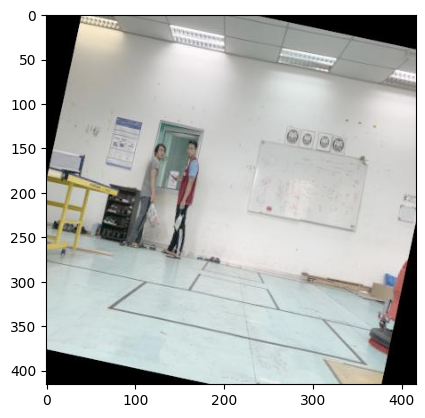

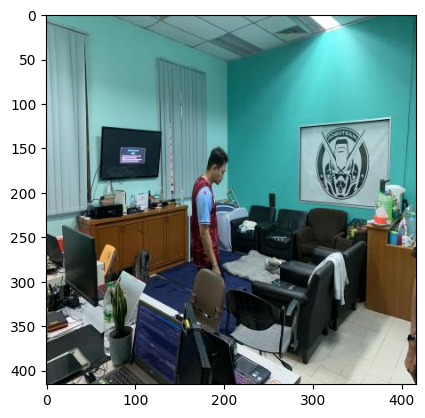

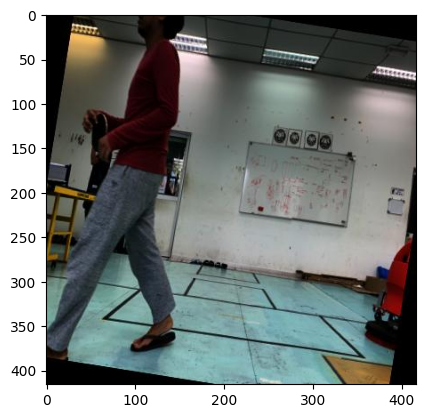

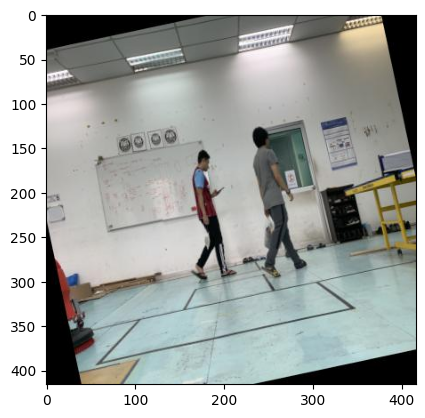

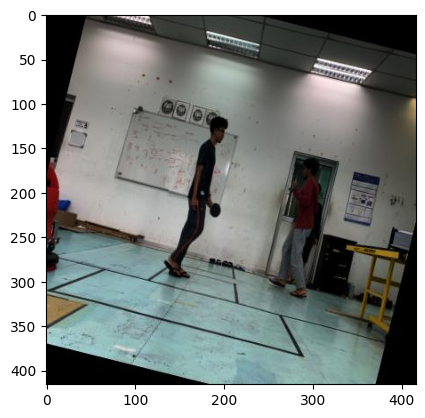

In [13]:
import cv2
import matplotlib.pyplot as plt
import glob

images_path = glob.glob("data/obj/*.jpg")

for img_path in images_path[:5]:  # Display first 5 images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


Checking Annotations

In [ ]:
with open('data/obj.names', 'r') as f:
    classes = f.read().strip().split('\n')
print("Classes:", classes)

# Display an example annotation file
with open(images_path[0].replace('.jpg', '.txt'), 'r') as f:
    annotations = f.read().strip().split('\n')
print("Annotations for first image:", annotations)


###5. Training the Model

Download Pre-trained Weights

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.conv.137 -O yolov4.conv.137


In [ ]:
ls

In [ ]:
#find the darknet executionable file

In [ ]:
!find /content -type f -executable -name "darknet"

Start Training

In [ ]:
!./darknet/darknet detector train data/obj.data darknet/cfg/custom-yolov4-detector.cfg yolov4.conv.137 -dont_show -map


###Testing the Model

Ensure the test image exists

In [ ]:
import shutil

test_image = 'data/obj/test.jpg'
shutil.copyfile('data/obj/<any_image_name>.jpg', test_image)


Testing on Images

In [ ]:
!./darknet detector test data/obj.data cfg/custom-yolov4-detector.cfg backup/custom-yolov4-detector_best.weights data/obj/test.jpg -thresh 0.5


Locate and Visualize Predictions

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('predictions.jpg')
if img is None:
    print("Error: predictions.jpg not found or empty.")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
